In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
farm_df = pd.read_csv('./data/farming_data.csv')

farm_df.head()

,farm_id,region,crop_type,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,irrigation_type,...,total_days,yield_kg_per_hectare,sensor_id,timestamp,latitude,longitude,NDVI_index,crop_disease_status,location,name
0,FARM0001,North India,Wheat,30.369286,6.536057,24.665972,148.283970,66.426936,7.065971,NaN,...,122,4408.07,SENS0001,2024-03-19,30.492804,77.321728,0.553567,Mild,Chandigarh,Autumn Acres
1,FARM0002,South USA,Soybean,32.307540,6.527467,26.639534,168.017947,70.986366,7.174682,Sprinkler,...,112,5389.98,SENS0002,2024-04-21,32.860297,-94.055091,0.586660,NaN,Arkansas,Autumn Farm
2,FARM0003,South USA,Wheat,19.089053,6.276386,25.304977,132.706446,59.555665,6.813413,Drip,...,144,2931.16,SENS0003,2024-02-28,31.009527,-91.053578,0.424947,Moderate,Louisiana,Autumn Farms
3,FARM0004,Central USA,Maize,21.156208,6.651671,26.075404,161.274245,64.718610,5.016075,Sprinkler,...,134,4227.80,SENS0004,2024-05-14,44.231602,-95.408510,0.566940,Mild,Minnesota,Autumn Field
4,FARM0005,Central USA,Cotton,19.331912,6.621555,26.592469,139.071452,74.975074,6.298073,NaN,...,105,4979.96,SENS0005,2024-04-13,44.545954,-118.820344,0.499213,Mild,Oregon,Autumn Fields


## Correlation Matrix

In [3]:
numeric_df = farm_df.select_dtypes(include='number')
corr_matrix = numeric_df.corr(method='pearson')
corr_matrix

corr_pairs = (
    corr_matrix
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'r'})
)

# Remove duplicates (A,B) and (B,A)
corr_pairs = corr_pairs[corr_pairs['var1'] < corr_pairs['var2']]

corr_pairs.sort_values('r', ascending=False)


,var1,var2,r
140,NDVI_index,yield_kg_per_hectare,0.927467
32,temperature_C,yield_kg_per_hectare,0.805554
8,soil_moisture_%,yield_kg_per_hectare,0.791872
80,pesticide_usage_ml,yield_kg_per_hectare,0.788889
44,rainfall_mm,yield_kg_per_hectare,0.754800
...,...,...,...
108,latitude,soil_moisture_%,-0.040963
19,soil_pH,total_days,-0.044867
31,temperature_C,total_days,-0.056374
67,sunlight_hours,total_days,-0.085111


In [4]:
farm_df.columns

Index(['farm_id', 'region', 'crop_type', 'soil_moisture_%', 'soil_pH',
       'temperature_C', 'rainfall_mm', 'humidity_%', 'sunlight_hours',
       'irrigation_type', 'fertilizer_type', 'pesticide_usage_ml',
       'sowing_date', 'harvest_date', 'total_days', 'yield_kg_per_hectare',
       'sensor_id', 'timestamp', 'latitude', 'longitude', 'NDVI_index',
       'crop_disease_status', 'location', 'name'],
      dtype='object')

## Health Status Index Calculation

In [5]:
num_cols = farm_df.select_dtypes(include="number").columns

exclude = ["latitude", "longitude", "sensor_id"]
num_cols = [c for c in num_cols if c not in exclude]

col_means = farm_df[num_cols].mean()

# absolute deviation
percentage_diff = ((farm_df[num_cols] - col_means).abs() / col_means) * 100

# row-wise mean deviation
farm_df["health_index"] = percentage_diff.mean(axis=1)

# central point of typical farms
middle_point = farm_df["health_index"].median()
farm_df["health_index"].sort_values(ascending=True)

cutoff = farm_df["health_index"].iloc[len(farm_df)//2]

locations = farm_df[["longitude", "latitude", "health_index"]].sort_values("health_index", ascending=True).to_dict(orient="records")
locations

[{'longitude': 76.596255,
  'latitude': 13.415321,
  'health_index': 4.028888975553576},
 {'longitude': 79.972159,
  'latitude': 28.080664,
  'health_index': 4.309509783628591},
 {'longitude': 36.292994,
  'latitude': 1.035867,
  'health_index': 4.637673384458279},
 {'longitude': -103.588329,
  'latitude': 36.41909,
  'health_index': 4.899404632537786},
 {'longitude': -104.850413,
  'latitude': 43.668716,
  'health_index': 4.952349365384251},
 {'longitude': 37.65068,
  'latitude': -4.833245,
  'health_index': 5.077885095978309},
 {'longitude': 77.587572,
  'latitude': 31.346436,
  'health_index': 5.237174001374973},
 {'longitude': 36.026876,
  'latitude': -0.172909,
  'health_index': 5.332750607962593},
 {'longitude': -111.108233,
  'latitude': 36.650298,
  'health_index': 5.495420572304251},
 {'longitude': 80.869596,
  'latitude': 28.207972,
  'health_index': 5.575352205746839},
 {'longitude': 37.023999,
  'latitude': -0.179014,
  'health_index': 5.636537192336656},
 {'longitude': -10

## Correlation of Variables

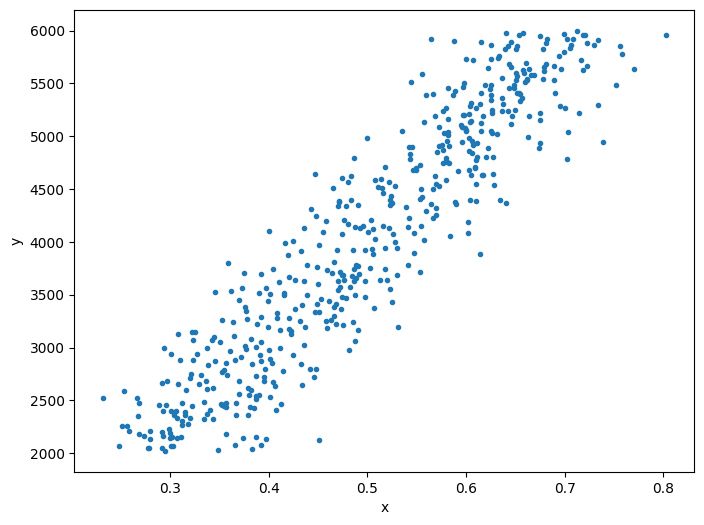

In [6]:
def scatter(x, y):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker='.')
    plt.xlabel('x')
    plt.ylabel('y')
    
x = farm_df["NDVI_index"]
y = farm_df["yield_kg_per_hectare"]
scatter(x, y)

## Gather Feature by Region

In [7]:
average_values = farm_df.groupby("region").mean(numeric_only=True).to_dict()
average_values["NDVI_index"]

{'Central USA': 0.49814265244714284,
 'East Africa': 0.5033142749013915,
 'North India': 0.48801239770481863,
 'South India': 0.5123032287092547,
 'South USA': 0.4956047715087231}

## Gather Scatterplot Data

In [8]:
def gather_scatterplot(x, y):
    # api use
    if not x in farm_df.describe().columns:
        return False
    if not y in farm_df.describe().columns:
        return False
    
    return {
        "x": farm_df[x],
        "y": farm_df[y]
    }
    

## Yield Crop Predictor

In [9]:
from sklearn.preprocessing import StandardScaler

numerical_columns = farm_df.describe().columns
display(numerical_columns)
scaler = StandardScaler()
farm_stand = scaler.fit_transform(farm_df[numerical_columns])
farm_stand = pd.DataFrame(farm_stand, columns=numerical_columns)
farm_stand

Index(['soil_moisture_%', 'soil_pH', 'temperature_C', 'rainfall_mm',
       'humidity_%', 'sunlight_hours', 'pesticide_usage_ml', 'total_days',
       'yield_kg_per_hectare', 'latitude', 'longitude', 'NDVI_index',
       'health_index'],
      dtype='object')

,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,pesticide_usage_ml,total_days,yield_kg_per_hectare,latitude,longitude,NDVI_index,health_index
0,1.101232,0.143231,-0.004865,-0.043491,0.557476,1.137877,0.101068,0.149214,0.319745,0.448178,0.979906,0.422920,-1.338012
1,1.489088,0.109835,0.582059,0.464799,0.984851,1.255393,1.706095,-0.446689,1.156654,0.597192,-1.118809,0.681037,0.401815
2,-1.156005,-0.866299,0.185170,-0.444722,-0.086597,0.864865,-0.292349,1.460202,-0.939066,0.480701,-1.082052,-0.580264,-0.518049
3,-0.742356,0.592708,0.414290,0.291101,0.397347,-1.078041,-0.605651,0.864299,0.166096,1.312919,-1.135383,0.527224,-0.980664
4,-1.107408,0.475623,0.568062,-0.280778,1.358730,0.307786,0.719220,-0.863822,0.807182,1.332705,-1.422089,-0.001018,-0.622662
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.387450,-0.746869,0.465941,1.567944,-0.408359,0.074599,-0.270888,1.102660,0.186211,1.465401,-1.213518,0.544075,-0.817999
496,0.266062,0.092967,0.069835,-0.291333,-1.046033,0.565750,0.438718,-0.923412,-0.276484,0.410270,0.999650,-0.967613,-0.992051
497,-0.874037,-1.600517,-0.864308,-2.351015,0.572424,0.013368,-1.051723,0.506756,-1.217564,0.359911,1.021517,-1.264207,0.811627
498,-0.880584,-0.161641,-1.137013,-1.303972,-0.430907,-0.988445,-1.315584,0.685527,-1.232949,0.857709,-1.120141,-1.924091,0.959163


In [10]:
u, s, vt = np.linalg.svd(farm_stand, full_matrices=False)

In [11]:
N = len(farm_stand)

singular_values = [singular_value**2/N for singular_value in s]
total_variance = np.sum(singular_values)

total_variance

np.float64(13.000000000000012)

In [12]:
farm_2d = farm_stand @ vt[[0,1]].T
farm_2d

,0,1
0,-1.246677,0.236274
1,-2.830654,-1.231521
2,1.186173,-1.080747
3,0.015851,-1.781928
4,-0.938920,-2.131181
...,...,...
495,-0.639072,-1.873886
496,0.412213,0.312807
497,2.899822,0.555296
498,3.268106,-1.236226


<Axes: xlabel='0', ylabel='1'>

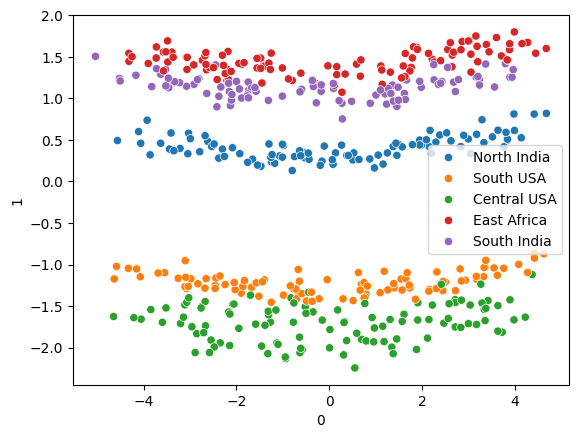

In [13]:
farm_target = farm_df["region"].values
sns.scatterplot(x = farm_2d.loc[:, 0], y = farm_2d.loc[:, 1], hue = farm_target)

## Linear Regression

In [14]:
numeric_df = farm_df.select_dtypes(include='number')
corr_matrix = numeric_df.corr(method='pearson')
corr_matrix

corr_pairs = (
    corr_matrix
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'r'})
)

# Remove duplicates (A,B) and (B,A)
corr_pairs = corr_pairs[corr_pairs['var1'] < corr_pairs['var2']]

corr_pairs.sort_values('r', ascending=False)

,var1,var2,r
151,NDVI_index,yield_kg_per_hectare,0.927467
34,temperature_C,yield_kg_per_hectare,0.805554
8,soil_moisture_%,yield_kg_per_hectare,0.791872
86,pesticide_usage_ml,yield_kg_per_hectare,0.788889
47,rainfall_mm,yield_kg_per_hectare,0.754800
...,...,...,...
33,temperature_C,total_days,-0.056374
165,health_index,latitude,-0.059809
72,sunlight_hours,total_days,-0.085111
156,health_index,soil_moisture_%,-0.098952


In [15]:
farm_df.columns

Index(['farm_id', 'region', 'crop_type', 'soil_moisture_%', 'soil_pH',
       'temperature_C', 'rainfall_mm', 'humidity_%', 'sunlight_hours',
       'irrigation_type', 'fertilizer_type', 'pesticide_usage_ml',
       'sowing_date', 'harvest_date', 'total_days', 'yield_kg_per_hectare',
       'sensor_id', 'timestamp', 'latitude', 'longitude', 'NDVI_index',
       'crop_disease_status', 'location', 'name', 'health_index'],
      dtype='object')

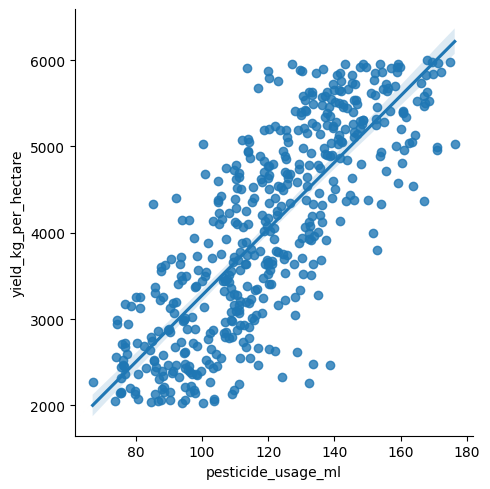

In [16]:
sns.lmplot(data = farm_df, x = "pesticide_usage_ml", y = "yield_kg_per_hectare");

In [17]:
feature_one = "pesticide_usage_ml"
feature_two = "yield_kg_per_hectare"

x = farm_df[feature_one]
y = farm_df[feature_two]

x_bar = np.mean(x)
y_bar = np.mean(y)

std_x = np.std(x)
std_y = np.std(y)

r = np.corrcoef(x, y)[0][1]
r

np.float64(0.7888890333589951)

In [18]:
b_hat = r * (std_y/std_x)
a_hat = y_bar - b_hat*x_bar

predict = lambda x: a_hat + b_hat * x

def predict_range_x_value(start_x):
    predictive_vals = []
    predicted_vals = []

    step_up = (max(x) - min(x)) * 0.03

    bound = predict(max(x)) * 1.20
    
    current_x = start_x
    current_y = predict(current_x)

    while current_y < bound:
        predictive_vals.append(current_x)
        predicted_vals.append(current_y)
        current_x += step_up
        current_y = predict(current_x)
    
    new = len(predictive_vals)
    
    return list(x) + predictive_vals, list(y) + predicted_vals, new

def set_value_ranges():
    
    return min(x), max(x) * 1.5
    


## PCA

In [20]:
farm_df.describe().columns

Index(['soil_moisture_%', 'soil_pH', 'temperature_C', 'rainfall_mm',
       'humidity_%', 'sunlight_hours', 'pesticide_usage_ml', 'total_days',
       'yield_kg_per_hectare', 'latitude', 'longitude', 'NDVI_index',
       'health_index'],
      dtype='object')

In [21]:
from sklearn.preprocessing import StandardScaler

farm = farm_df[farm_df.describe().columns].drop(columns=["latitude", "longitude", "total_days"]).dropna()
farm_target = farm_df["health_index"].values


In [22]:
scaler = StandardScaler()
farm_stand = scaler.fit_transform(farm)
farm_stand = pd.DataFrame(farm_stand, columns=farm.columns)
farm_stand

,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,pesticide_usage_ml,yield_kg_per_hectare,NDVI_index,health_index
0,1.101232,0.143231,-0.004865,-0.043491,0.557476,1.137877,0.101068,0.319745,0.422920,-1.338012
1,1.489088,0.109835,0.582059,0.464799,0.984851,1.255393,1.706095,1.156654,0.681037,0.401815
2,-1.156005,-0.866299,0.185170,-0.444722,-0.086597,0.864865,-0.292349,-0.939066,-0.580264,-0.518049
3,-0.742356,0.592708,0.414290,0.291101,0.397347,-1.078041,-0.605651,0.166096,0.527224,-0.980664
4,-1.107408,0.475623,0.568062,-0.280778,1.358730,0.307786,0.719220,0.807182,-0.001018,-0.622662
...,...,...,...,...,...,...,...,...,...,...
495,0.387450,-0.746869,0.465941,1.567944,-0.408359,0.074599,-0.270888,0.186211,0.544075,-0.817999
496,0.266062,0.092967,0.069835,-0.291333,-1.046033,0.565750,0.438718,-0.276484,-0.967613,-0.992051
497,-0.874037,-1.600517,-0.864308,-2.351015,0.572424,0.013368,-1.051723,-1.217564,-1.264207,0.811627
498,-0.880584,-0.161641,-1.137013,-1.303972,-0.430907,-0.988445,-1.315584,-1.232949,-1.924091,0.959163


In [23]:
u, s, vt = np.linalg.svd(farm_stand, full_matrices=False)

N = len(farm_stand)

singular_values = [singular_value**2/N for singular_value in s]
total_variance = np.sum(singular_values)

total_variance

np.float64(10.000000000000005)

In [24]:
farm_2d = farm_stand @ vt[[0,1]].T
farm_2d

,0,1
0,-1.243943,1.441135
1,-2.841380,-0.335981
2,1.146786,0.436679
3,-0.023364,0.811956
4,-0.953074,0.336527
...,...,...
495,-0.684376,0.962078
496,0.433891,0.962203
497,2.898800,-0.741840
498,3.237592,-0.927509


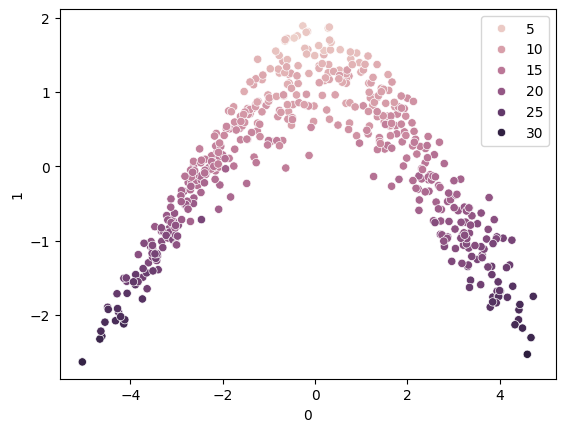

In [25]:


sns.scatterplot(x = farm_2d.loc[:, 0], y = farm_2d.loc[:, 1], hue = farm_target)
plt.show()

In [28]:
proportions = singular_values/np.sum(singular_values)
farm_2d_variance = proportions[0] + proportions[1] # PC1 + PC2
farm_2d_variance

np.float64(0.7075795346910068)